In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spots = {
    'go': 0,
    'jail': 10,
    'g2j': 30,
    # Spots you are sent to by chance
    'chspots': np.array([0, 11, 24, 39, 5]),
    # Locations of chance and community chest
    'ch': np.array([7, 22, 36]),
    'cc': np.array([2, 17, 33]),
    # Locations of railroads and utilities
    'rrs': np.array([5, 15, 25, 35]), 
    'utils': np.array([12, 28])
}

moveSpots = np.concatenate([spots['ch'], spots['cc'], np.array([spots['g2j']])])

In [32]:
boolStrs = {False: 'F', True: 'T'}

shouldDebugPrint = False
def debugPrint(m):
    if shouldDebugPrint: print('\t', m)

In [5]:
class GameState:
    def __init__(self):
        self.loc = 0
        self.doubleCount = 0
        self.jailCount = 0
        self.inJail = False
    
    def copy(self):
        g = GameState()
        g.loc = self.loc
        g.doubleCount = self.doubleCount
        g.jailCount = self.jailCount
        g.inJail = self.inJail
        return g
    
    def goToJail(self):
        debugPrint('-- Go to jail --')
        self.inJail = True
        self.loc = spots['jail']
        
    def __str__(self):
        return 'GS({} j:{} dc:{} jc:{})'.format(
            str(self.loc), boolStrs[self.inJail], str(self.doubleCount), str(self.jailCount)
        )

In [7]:
def d6():
    return np.random.randint(6) + 1

def move(s, ds): 
    return (s + ds) % 40

def getNext(s, choices):
    dsVals = (choices - s) % 40
    choiceIdx = np.argmin(dsVals)
    return choices[choiceIdx]

In [8]:
def takeTurnFullJail(cs):
    roll1, roll2 = d6(), d6()
    roll = roll1 + roll2
    
    debugPrint('Roll: {} ({} + {})'.format(roll, roll1, roll2))
    
    ns = cs.copy()
    
    shouldMove = True
    startedInJail = ns.inJail
    
    # Jail rules
    if cs.inJail:
        debugPrint('In jail...')
        shouldMove = False
        ns.jailCount += 1
        if (roll1 == roll2) or (ns.jailCount == 3):
            debugPrint('Leaving jail!')
            ns.inJail = False
            ns.jailCount = 0
            shouldMove = True
    
    # "Three doubles" rules
    if (roll1 == roll2) and not startedInJail:
        ns.doubleCount += 1
        debugPrint('Doubles... (count={})'.format(ns.doubleCount))
        if ns.doubleCount == 3:
            debugPrint('Third doubles!')
            ns.goToJail()
            shouldMove = False
    else:
        ns.doubleCount = 0
    
    # Move normally
    if shouldMove: ns.loc = move(ns.loc, roll)
    
    # If landed on a spot with movement rules...
    while ns.loc in moveSpots:
        
        # Chance movement rules
        if ns.loc in spots['ch']:
            choice = np.random.randint(16)
            debugPrint('Chance! Choice = {}'.format(choice))
            
            # Go to predetermined spot
            if choice <= 4: ns.loc = spots['chspots'][choice]
            
            # Go to next railroad
            elif choice <= 6: ns.loc = getNext(ns.loc, spots['rrs'])
            
            # Go to next utility
            elif choice == 7: ns.loc = getNext(ns.loc, spots['utils'])
            
            # Go back 3
            elif choice == 8: ns.loc = move(ns.loc, -3)
            
            # Go to jail
            elif choice == 9: ns.goToJail()
                
            # Otherwise, no movement
            else: break
            
        # Community Chest movement rules
        if ns.loc in spots['cc']:
            choice = np.random.randint(16)
            debugPrint('CC! Choice = {}'.format(choice))
            
            # Go to go
            if choice == 0: ns.loc = spots['go']
            
            # Go to jail
            if choice == 1: ns.goToJail()
            
            # Otherwise, no movement
            else: break
        
        # Go to Jail movement rules
        if ns.loc == spots['g2j']:
            debugPrint('G2J spot!')
            ns.goToJail()
    
    # Done!
    return ns

In [26]:
def takeTurn(cs):
    roll1, roll2 = d6(), d6()
    roll = roll1 + roll2
    
    debugPrint('Roll: {} ({} + {})'.format(roll, roll1, roll2))
    
    ns = cs.copy()
    
    shouldMove = True
    startedInJail = ns.inJail
    
    # Jail rules
    if ns.inJail:
        debugPrint('In jail...')
        ns.inJail = False
    
    # "Three doubles" rules
    if (roll1 == roll2) and not startedInJail:
        ns.doubleCount += 1
        debugPrint('Doubles... (count={})'.format(ns.doubleCount))
        if ns.doubleCount == 3:
            debugPrint('Third doubles!')
            ns.goToJail()
            shouldMove = False
    else:
        ns.doubleCount = 0
    
    # Move normally
    if shouldMove: ns.loc = move(ns.loc, roll)
    
    # If landed on a spot with movement rules...
    while ns.loc in moveSpots:
        
        # Chance movement rules
        if ns.loc in spots['ch']:
            choice = np.random.randint(16)
            debugPrint('Chance! Choice = {}'.format(choice))
            
            # Go to predetermined spot
            if choice <= 4: ns.loc = spots['chspots'][choice]
            
            # Go to next railroad
            elif choice <= 6: ns.loc = getNext(ns.loc, spots['rrs'])
            
            # Go to next utility
            elif choice == 7: ns.loc = getNext(ns.loc, spots['utils'])
            
            # Go back 3
            elif choice == 8: ns.loc = move(ns.loc, -3)
            
            # Go to jail
            elif choice == 9: ns.goToJail()
                
            # Otherwise, no movement
            else: break
            
        # Community Chest movement rules
        if ns.loc in spots['cc']:
            choice = np.random.randint(16)
            debugPrint('CC! Choice = {}'.format(choice))
            
            # Go to go
            if choice == 0: ns.loc = spots['go']
            
            # Go to jail
            if choice == 1: ns.goToJail()
            
            # Otherwise, no movement
            else: break
        
        # Go to Jail movement rules
        if ns.loc == spots['g2j']:
            debugPrint('G2J spot!')
            ns.goToJail()
    
    # Done!
    return ns


In [33]:
counts = {s: 0 for s in range(40)}

nGames = 20000
turnsPerGame = 40
for n in range(nGames):
    gs = GameState()
    for t in range(turnsPerGame):
        gs = takeTurn(gs)
        counts[gs.loc] += 1

In [34]:
for l, c in counts.items(): print(l, c)

0 23591
1 15786
2 14544
3 17135
4 19353
5 24770
6 19618
7 7731
8 20328
9 19777
10 50088
11 22447
12 21535
13 19339
14 20366
15 24232
16 22904
17 20932
18 23807
19 24903
20 22843
21 22767
22 8440
23 21680
24 25365
25 24429
26 21390
27 21313
28 21798
29 20434
30 0
31 20581
32 20125
33 18261
34 19172
35 18486
36 6575
37 16575
38 16534
39 20046


In [16]:
from PIL import Image

img = Image.open("monopoly.jpg")
pix = img.load()
photoData = (np.array([[pix[i,j] for i in range(img.width)] for j in range(img.height)])/255.)

px, py, _ = photoData.shape

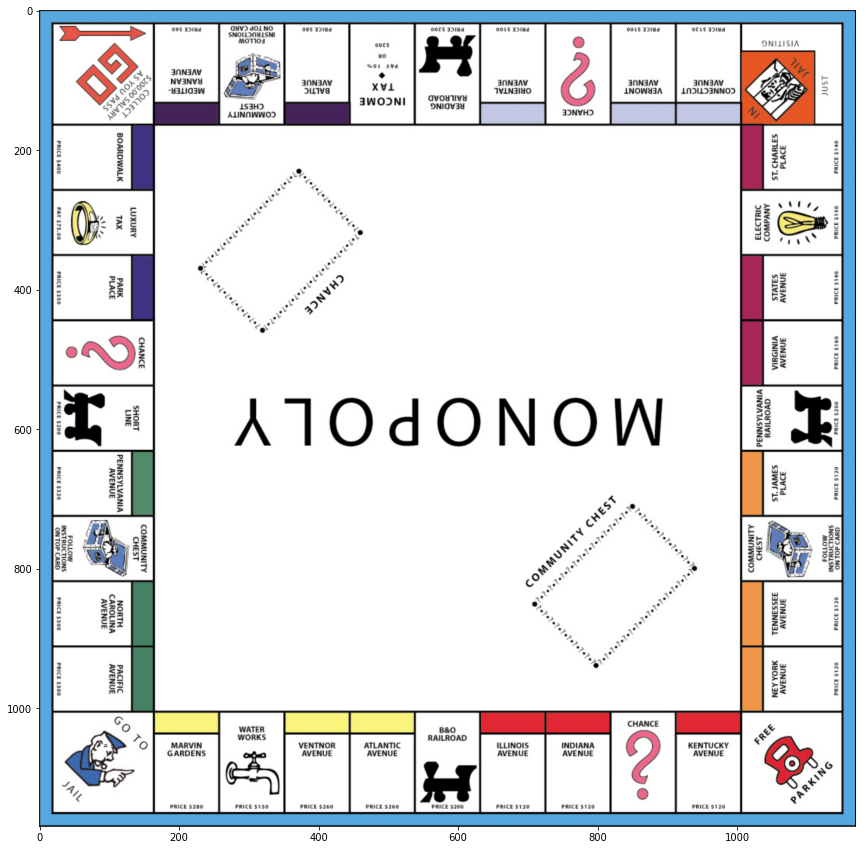

In [57]:
plt.figure(figsize=(15,15))
plt.imshow(np.rot90(photoData, 2), interpolation='gaussian')

In [133]:
# Initial rent per cost for all properties

rpcInit = np.array([0]*40).astype(float)
rpcInit[1] = 2 / 60
rpcInit[3] = 4 / 60
rpcInit[6] = 6 / 100
rpcInit[8] = 6 / 100
rpcInit[9] = 8 / 120
rpcInit[11] = 10 / 140
rpcInit[13] = 10 / 140
rpcInit[14] = 12 / 160
rpcInit[16] = 14 / 180
rpcInit[18] = 14 / 180
rpcInit[19] = 16 / 200
rpcInit[21] = 18 / 220
rpcInit[23] = 18 / 220
rpcInit[24] = 20 / 240
rpcInit[26] = 22 / 260
rpcInit[27] = 22 / 260
rpcInit[29] = 24 / 280
rpcInit[31] = 26 / 300
rpcInit[32] = 26 / 300
rpcInit[34] = 28 / 320
rpcInit[37] = 35 / 350
rpcInit[39] = 50 / 400
rpcInit[12] = 28 / 150
rpcInit[28] = 28 / 150
rpcInit[5] = 25 / 200
rpcInit[15] = 25 / 200
rpcInit[25] = 25 / 200
rpcInit[35] = 25 / 200

# Final, fully-decked out rent for all properties

rentFinal = np.array([0]*40).astype(float)
rentFinal[1] = 250
rentFinal[3] = 450
rentFinal[6] = 550
rentFinal[8] = 550
rentFinal[9] = 600
rentFinal[11] = 750
rentFinal[13] = 750
rentFinal[14] = 900
rentFinal[16] = 950
rentFinal[18] = 950
rentFinal[19] = 1000
rentFinal[21] = 1050
rentFinal[23] = 1050
rentFinal[24] = 1100
rentFinal[26] = 1150
rentFinal[27] = 1150
rentFinal[29] = 1200
rentFinal[31] = 1275
rentFinal[32] = 1275
rentFinal[34] = 1400
rentFinal[37] = 1500
rentFinal[39] = 2000
rentFinal[12] = 70
rentFinal[28] = 70
rentFinal[5] = 200
rentFinal[15] = 200
rentFinal[25] = 200
rentFinal[35] = 200




In [134]:
def plotValuesAroundBoard(values, comparison, ax):

    trim = 6.25
    ctr = 4.5

    c = [(.75, .75, .75)] * 40
    # c = [(1, 1, 1, 0)] * 40
    c[1] = c[3] =           (68 /255, 35 /255, 90 /255)
    c[6] = c[8] = c[9] =    (196/255, 200/255, 229/255)
    c[11] = c[13] = c[14] = (167/255, 39 /255, 88 /255)
    c[16] = c[18] = c[19] = (241/255, 151/255, 73 /255)
    c[21] = c[23] = c[24] = (225/255, 40 /255, 51 /255)
    c[26] = c[27] = c[29] = (249/255, 244/255, 124/255)
    c[31] = c[32] = c[34] = (70 /255, 130/255, 102/255)
    c[37] = c[39] =         (65 /255, 51 /255, 130/255)

    barAlpha=0.3
    
    ax.imshow(np.rot90(photoData, k=2), interpolation='bilinear', extent=(ctr-trim,ctr+trim,-ctr-trim,-ctr+trim))
    ax.bar(spaces[1:10]-1, values[1:10], align='edge', color=c[1:10], alpha=barAlpha, edgecolor=c[1:10], hatch='X', width=1, bottom=0)
    ax.barh(10-spaces[11:20], values[11:20], align='edge', color=c[11:20], alpha=barAlpha, edgecolor=c[11:20], hatch='X', height=1, left=9)
    ax.bar(30-spaces[21:30]-1, -values[21:30], align='edge', color=c[21:30], alpha=barAlpha, edgecolor=c[21:30], hatch='X', width=1, bottom=-9)
    ax.barh(spaces[31:40]-40, -values[31:40], align='edge', color=c[31:40], alpha=barAlpha, edgecolor=c[31:40], hatch='X', height=1, left=0)

    ax.fill([0, 0-values[0], 0-values[0], 0], [0, 0, 0+values[0], 0+values[0]], color=c[0], alpha=barAlpha, edgecolor=c[0], hatch='X')
    ax.fill([9, 9+values[10], 9+values[10], 9], [0, 0, 0+values[10], 0+values[10]], color=c[10], alpha=barAlpha, edgecolor=c[10], hatch='X')
    ax.fill([9, 9+values[20], 9+values[20], 9], [-9, -9, -9-values[20], -9-values[20]], color=c[20], alpha=barAlpha, edgecolor=c[20], hatch='X')
    
    ax.plot([-comparison, 9+comparison, 9+comparison, -comparison, -comparison], [comparison, comparison, -9-comparison, -9-comparison, comparison], color='gray', linestyle='--', linewidth=2)
    
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_aspect(1)
    ax.set_axis_off()


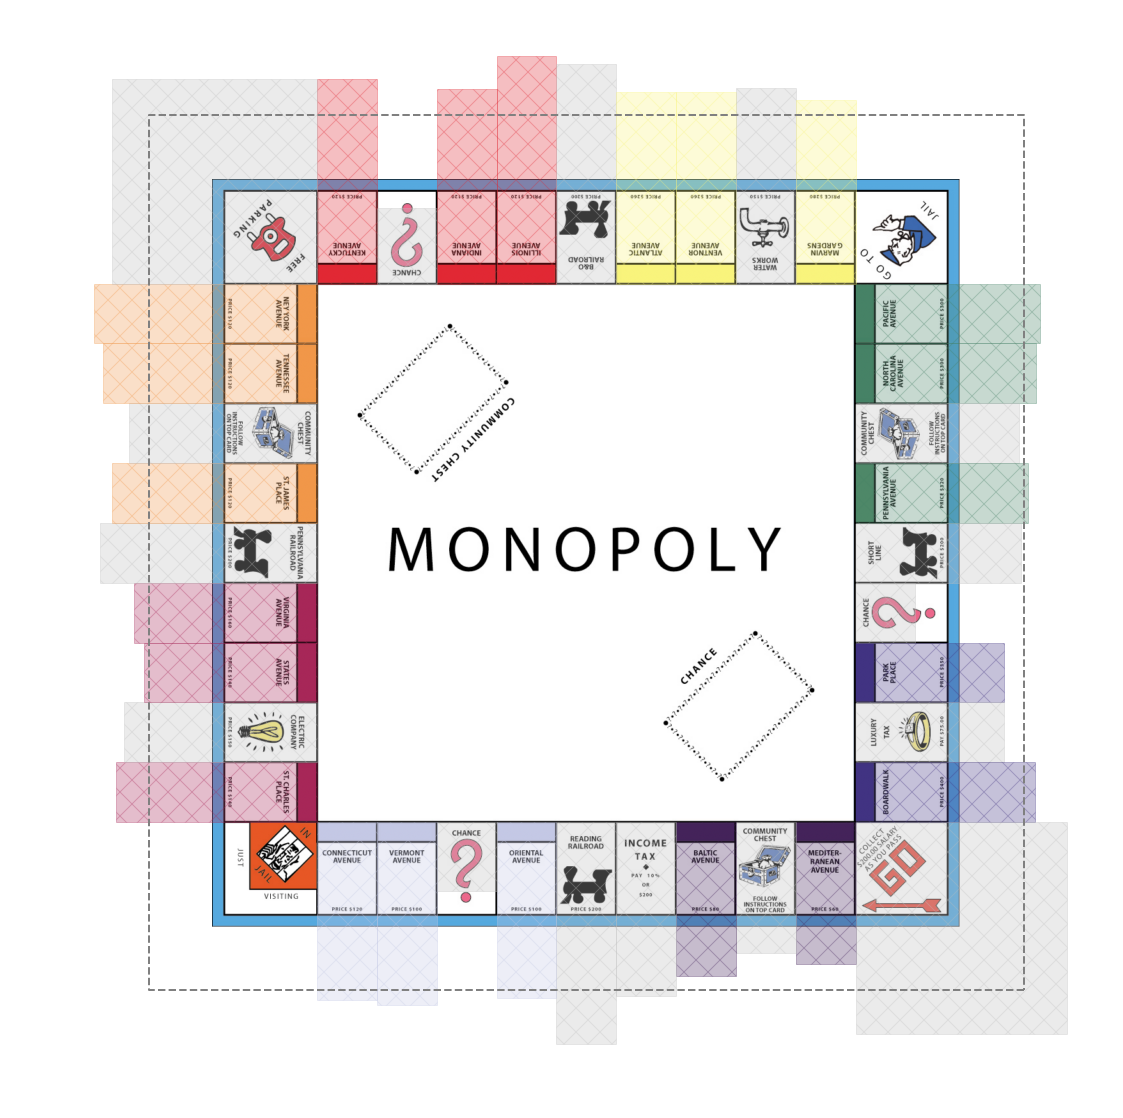

In [135]:
spaces = np.array(list(counts.keys()))
countsArr = np.array(list(counts.values()))
probs = countsArr / np.sum(countsArr)

probs[10] = 0 # Jail is too big

mul = 120

f, ax = plt.subplots(1,1, figsize=(20,20))
f.patch.set_facecolor('white')
plotValuesAroundBoard(mul * probs, mul* np.mean(probs), ax)

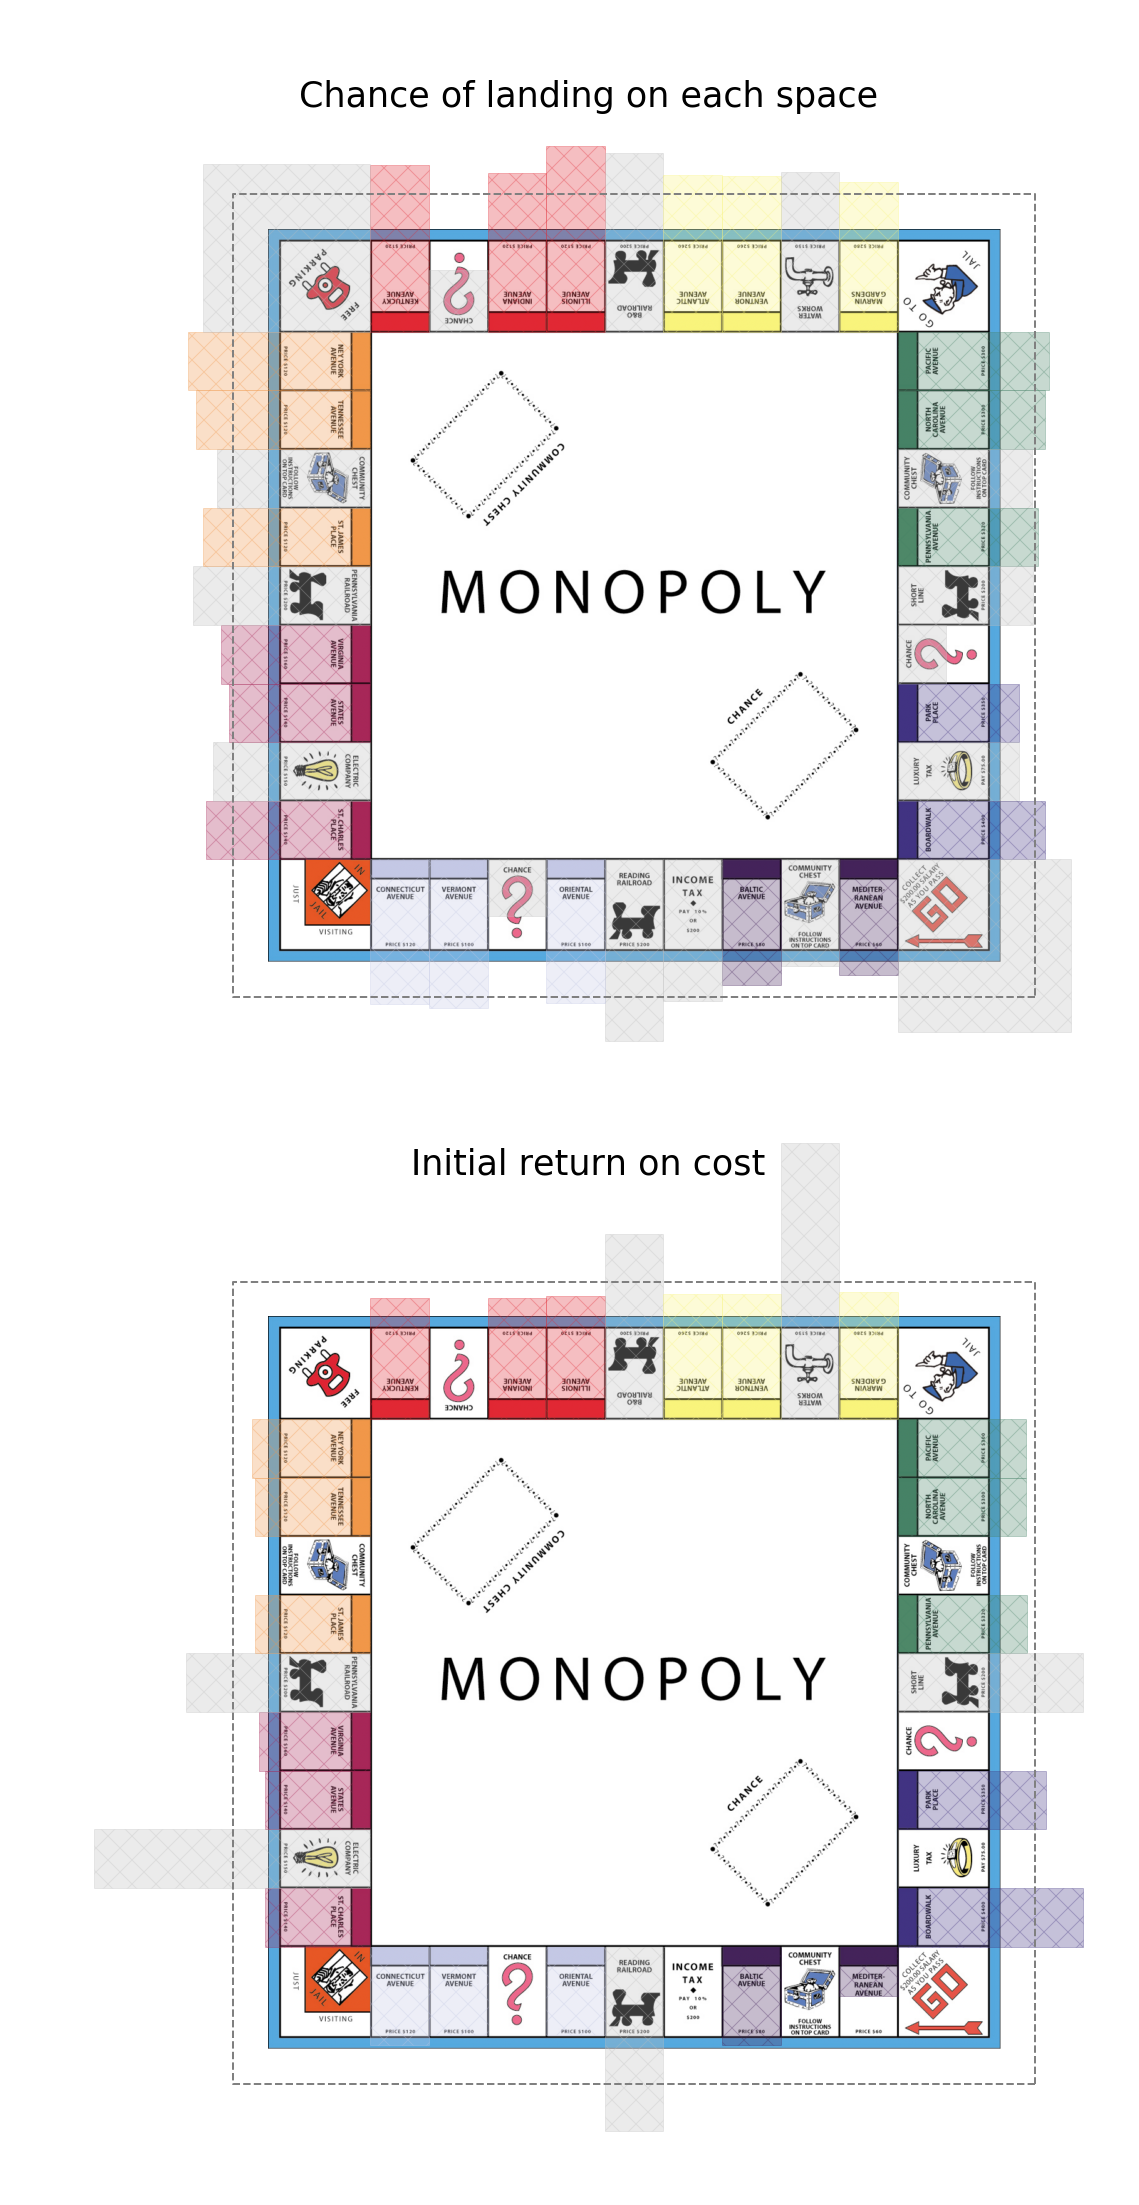

In [151]:
meanProbs = np.mean(probs)

meanRPCInit = np.mean(rpcInit[rpcInit > 0])

rpcInitProbWeighted = probs * rpcInit
meanRPCInitProbWeighted = np.mean(rpcInitProbWeighted[rpcInitProbWeighted > 0])

mul1 = 100
mul2 = mul1 * meanProbs / meanRPCInit
mul3 = mul1 * meanProbs / meanRPCInitProbWeighted

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,40), sharey=True, sharex=True)

f.patch.set_facecolor('white')

plotValuesAroundBoard(mul1 * probs, mul1 * np.mean(probs), ax1)
plotValuesAroundBoard(mul2 * rpcInit, mul2 * meanRPCInit, ax2)
# plotValuesAroundBoard(mul3 * rpcInitProbWeighted, mul3 * meanRPCInitProbWeighted, ax3)

plt.subplots_adjust(hspace=0)

ax1.set_title('Chance of landing on each space', fontsize=35, pad=-100)
ax2.set_title('Initial return on cost', fontsize=35, pad=-80)
# ax3.set_title('Initial return per cost (weighted by probability)', fontsize=30, pad=-30)

plt.show()